In [26]:
import pygmsh
import meshio
import pygalmesh
import hoomd
import hoomd.md
import numpy as np
import copy
import optimesh
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json

# Helper Functions

## Dolfin

In [27]:
def MakeDolfinMesh(a, edgepoints):
    # make the mesh. Lets have a unit circle. It seems, from trial and error, that
    # res = 1.5*Radius/mesh_size,
    domain = Ellipse(Point(0, 0, 0),1.0,1.0, edgepoints)
    mesh = generate_mesh(domain, 1.5/a)
    
    mesh.init()
    
    # need to add a 3rd dimension 0 coordinate here
    points = np.insert(mesh.coordinates(),2,0,axis=1)
    cells = cells = [("triangle",mesh.cells() )]
    InputMesh = meshio.Mesh(points,cells)
    #copy for modifying at output
    OutputMesh=copy.deepcopy(InputMesh)
    
    # make list of:
    #interior bonds : interiorbonds
    # edge bonds :edgepoints
    # bonds : interiorbonds+edgebonds
    # angle triples: angletriples
    mesh.cells()
    triangles=mesh.cells()
    x = [[[triangle[0],triangle[1]],[triangle[0],triangle[2]],[triangle[1],triangle[2]] ]   for triangle in triangles]
    flattenedx = [val for sublist in x for val in sublist]
    bonds = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in flattenedx]

    # get a list of the bonds on the edge, and in the interior
    edgebonds=[]
    interiorbonds=[]
    for elem in bonds:
        if 1==bonds.count(elem):
            edgebonds.append(elem)
        elif 2==bonds.count(elem) and elem not in interiorbonds:
            interiorbonds.append(elem)

    bonds=interiorbonds+edgebonds

    # for the edge bonds, get the angle triples
    EdgeVertices = list(set([val for sublist in edgebonds for val in sublist]))
    angletriples=[]

    for vertex in EdgeVertices:
        Neighbors=[x for x in edgebonds if vertex in x]
        NeighborVertices = [val for sublist in Neighbors for val in sublist if val!=vertex]
        angletriples.append([NeighborVertices[0],vertex,NeighborVertices[1]])
        
    return InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples


## pygmesh

In [28]:
def MakePygMesh():
    
    with pygmsh.occ.Geometry() as geom:
        geom.characteristic_length_max = 1
        geom.add_disk([0.0, 0.0], radius0=10.0,radius1=9.0,mesh_size=0.5),
        InputMesh = geom.generate_mesh()
    
    OutputMesh=copy.deepcopy(InputMesh)
    
    # make list of:
    #interior bonds : interiorbonds
    #edge bonds :edgepoints
    # angle triples: angletriples

    triangles=InputMesh.cells[1].data
    x = [[[triangle[0],triangle[1]],[triangle[0],triangle[2]],[triangle[1],triangle[2]] ]   for triangle in triangles]
    flattenedx = [val for sublist in x for val in sublist]
    orderedx = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in flattenedx]
    bonds = []

    bonds = []
    for elem in orderedx:
        if elem not in bonds:
            bonds.append(elem)

    # sort the edge bonds
    edgebonds = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in InputMesh.cells[0].data]
    interiorbonds=[x for x in bonds if x not in edgebonds]
    bonds=interiorbonds+edgebonds

    # Angle triples
    NEdgeBonds= len(edgebonds)
    angletriples=[[(i-1)%NEdgeBonds,i,(i+1)%NEdgeBonds] for i in range(0,NEdgeBonds) ]
    
    return InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples
    

In [29]:
def MakeBondHist(Coordinates,bondlist):
    lengths=[np.linalg.norm(Coordinates[bond[1]] -Coordinates[bond[0]]) for bond in bondlist]
    plt.hist(lengths)
    return lengths

# Initialisation

## Run setup

User settings: What are the continuum parameters we want? 

In [30]:
# Target mesh size:
target_a = 0.1
# continuum bending modulus:
kc=1
# continuum shear modulus:
mu=1
# particle mass
m = 1
# damping coefficient
alpha=2
g0=6
# dt
mydt = 0.003
#logging interval
LogInterval=10000
# Total run steps
RunSteps=10000000

Right, lets define the bond type and parameters for each bond. In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [31]:
kd=kc/target_a
k = mu
#theta0 = np.pi-((2*np.pi)/len(edgebonds))
theta0=np.pi

Set up the experiment

In [32]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
RunFolder="g0"+str(g0)+"/"
# Name of the run
RunName="Disk"

path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder if there was a previous run in it
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        

#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "mu":mu,
        "m":m,
        "alpha":alpha,
        "go":g0,
        "mydt":mydt,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump this file into the data file too

Successfully created the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/NeoHookean/Data/g06/ 


Make the mesh, write it out to the folder

In [35]:
InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples = MakeDolfinMesh(target_a,40)
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk")
#InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples = MakePygMesh()

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.07845909572784494

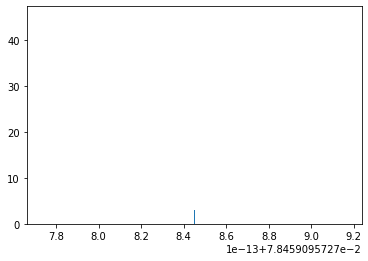

In [36]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

 ## Running the HOOMD sim

In [37]:
hoomd.context.initialize("");

Define the snapshot. We will have a unique bond id for every bond in the system, as they will all have different rest lengths. We also want to make a distinction between surface and bulk bonds.

In [38]:
# number of points and bonds
Npts=len(InputMesh.points);
bonds = interiorbonds+edgebonds
NBonds = len(bonds);
#indices
bondindices = list(range(0,NBonds))
#surface bond or not
bondclassification = [0]*len(interiorbonds)+[1]*len(edgebonds)

In [39]:
snapshot = hoomd.data.make_snapshot(N=Npts
                                    ,box=hoomd.data.boxdim(Lx=200, Ly=200,dimensions=2)
                                    ,particle_types=['A']
                                    ,bond_types=[str(i) for i in  bondindices]
                                    ,angle_types=['0']   
                                   );

Read in the points, bonds and angles

In [40]:
# points
snapshot.particles.position[:] = InputMesh.points;
snapshot.particles.typeid[0:Npts]=0
# mass
snapshot.particles.mass[:]=m
# bonds
snapshot.bonds.resize(NBonds)
snapshot.bonds.group[:] = bonds
snapshot.bonds.typeid[:] = bondindices
#angle triples
snapshot.angles.resize(len(angletriples))
snapshot.angles.group[:] = angletriples
snapshot.angles.typeid[:len(angletriples)] =0

make the initialisation

In [41]:
system=hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 496 particles


## Bond definitions

In [42]:
def NeoHookean(r,rmin,rmax,khook,r0):
    kneo = (r0**2)*khook/3
    lam=r/r0
    V=(kneo/2)*((2/lam) + lam**2)
    F = -(kneo/r0)*(  lam - (1/lam**2)  )
    return (V,F)

In [43]:
def myharmonic(r, rmin, rmax, kappa, r0):
   V = 0.5 * kappa * (r-r0)**2;
   F = -kappa*(r-r0);
   return (V, F)

In [44]:
kappa=1
r0=1
rmin=1
rmax=1

xlist = np.linspace(0.5,2, num=20)
dataNeo = [NeoHookean(x,rmin,rmax,kappa,r0)[1] for x in xlist]
dataHook = [myharmonic(x,rmin,rmax,kappa,r0)[1] for x in xlist]

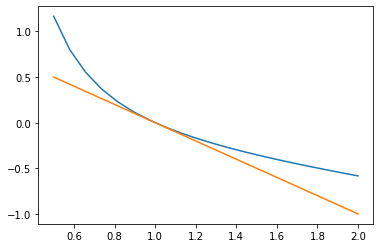

In [45]:
fig, ax = plt.subplots()
ax.plot(xlist, dataNeo)
ax.plot(xlist, dataHook)

In [46]:
NeoHookeanbond = hoomd.md.bond.table(width=300)

for i in snapshot.bonds.typeid:
    p1,p2 = snapshot.bonds.group[i]
    
    if(0==bondclassification[i]):
 
        InitLength=np.linalg.norm(InputMesh.points[p2] - InputMesh.points[p1])
        NeoHookeanbond.bond_coeff.set(str(i), func=NeoHookean, rmin=0.5*InitLength,rmax=15*InitLength, coeff=dict(khook=k,r0=InitLength));

    if(1==bondclassification[i]):

        restlength=np.linalg.norm(InputMesh.points[p2] - InputMesh.points[p1])
        NeoHookeanbond.bond_coeff.set(str(i), func=NeoHookean, rmin=0.5*InitLength,rmax=15*InitLength, coeff=dict(khook=k,r0=g0*InitLength));


angle = hoomd.md.angle.harmonic();
angle.angle_coeff.set('0', k=kd, t0=theta0 );

Define the integrator. In this case, a langevin dynamics. For the damping, particle diameters are set to 1 by default. The $\lambda$ parameter below is such that $\gamma = \lambda d$, so I just have $\gamma=\lambda$. The overdamped assumption is that $m/\gamma  << dt$

In [47]:
integrator_mode=hoomd.md.integrate.mode_standard(dt=mydt);
all = hoomd.group.all();
integrator = hoomd.md.integrate.langevin(group=all,kT=0,seed=0,dscale=alpha);

notice(2): integrate.langevin/bd is determining gamma from particle diameters


Define a callback, which we want run periodically

In [48]:
class WritePositions:
    def __init__(self, system):
        self.system = system;
    def __call__(self, timestep):
        snap = self.system.take_snapshot();
        OutputMesh.points = snap.particles.position
        OutputMesh.write(DataFolder+RunFolder+RunName+str(timestep)+".vtk")
        
hoomd.analyze.callback(callback=WritePositions(system), period=LogInterval);

In [49]:
snap=system.take_snapshot(all=True)

# Run the simulation

In [50]:
hoomd.run(RunSteps);

** starting run **
Time 00:00:13 | Step 54730 / 10000000 | TPS 5472.96 | ETA 00:30:17
Time 00:00:23 | Step 111107 / 10000000 | TPS 5637.68 | ETA 00:29:14
Time 00:00:33 | Step 167889 / 10000000 | TPS 5678.16 | ETA 00:28:51
Time 00:00:43 | Step 226685 / 10000000 | TPS 5879.53 | ETA 00:27:42
Time 00:00:53 | Step 284957 / 10000000 | TPS 5827.16 | ETA 00:27:47
Time 00:01:03 | Step 343237 / 10000000 | TPS 5827.92 | ETA 00:27:36
Time 00:01:13 | Step 398758 / 10000000 | TPS 5552.03 | ETA 00:28:49
Time 00:01:23 | Step 457383 / 10000000 | TPS 5862.48 | ETA 00:27:07
Time 00:01:33 | Step 515814 / 10000000 | TPS 5843.01 | ETA 00:27:03
Time 00:01:43 | Step 572525 / 10000000 | TPS 5671.05 | ETA 00:27:42
Time 00:01:53 | Step 621753 / 10000000 | TPS 4922.75 | ETA 00:31:45
Time 00:02:03 | Step 666958 / 10000000 | TPS 4520.47 | ETA 00:34:24
Time 00:02:13 | Step 721428 / 10000000 | TPS 5446.98 | ETA 00:28:23
Time 00:02:23 | Step 779033 / 10000000 | TPS 5760.44 | ETA 00:26:40
Time 00:02:33 | Step 835266 / 

Time 00:20:03 | Step 6045012 / 10000000 | TPS 5595.03 | ETA 00:11:46
Time 00:20:13 | Step 6102208 / 10000000 | TPS 5719.54 | ETA 00:11:21
Time 00:20:23 | Step 6158395 / 10000000 | TPS 5618.6 | ETA 00:11:23
Time 00:20:33 | Step 6217298 / 10000000 | TPS 5890.24 | ETA 00:10:42
Time 00:20:43 | Step 6276558 / 10000000 | TPS 5925.95 | ETA 00:10:28
Time 00:20:53 | Step 6334812 / 10000000 | TPS 5825.33 | ETA 00:10:29
Time 00:21:03 | Step 6392428 / 10000000 | TPS 5761.59 | ETA 00:10:26
Time 00:21:13 | Step 6451425 / 10000000 | TPS 5899.68 | ETA 00:10:01
Time 00:21:23 | Step 6505625 / 10000000 | TPS 5419.96 | ETA 00:10:44
Time 00:21:33 | Step 6553580 / 10000000 | TPS 4795.41 | ETA 00:11:58
Time 00:21:43 | Step 6604088 / 10000000 | TPS 5050.75 | ETA 00:11:12
Time 00:21:53 | Step 6652232 / 10000000 | TPS 4814.37 | ETA 00:11:35
Time 00:22:03 | Step 6701001 / 10000000 | TPS 4876.87 | ETA 00:11:16
Time 00:22:13 | Step 6746403 / 10000000 | TPS 4540.13 | ETA 00:11:56
Time 00:22:23 | Step 6791301 / 1000